## 1. Function definitions

In [3]:
import pandas as pd
from scipy.stats import entropy
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
from scipy.optimize import root_scalar, minimize_scalar
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

In [105]:
import numpy as np

def gen_data(bearings, n_bearings, n_features, samples_per_bearing, ab, af):

    """
    Generate synthetic data.
    Parameters:
    bearings: list of int, indices of bearings to include
    """
    assert max(bearings) < n_bearings
    assert n_features >= n_bearings + 1
    assert n_bearings % 2 == 0
    X = np.zeros((0, n_features))
    Y = np.zeros(0, dtype=int)
    for j in bearings:
        y = j % 2
        x = np.random.normal(size=(samples_per_bearing, n_features))
        x += ab*np.eye(n_features)[j]
        x += y*af*np.eye(n_features)[n_bearings:].sum(axis=0)
        y = np.tile(y, samples_per_bearing)
        X = np.r_[X, x]
        Y = np.r_[Y, y]
    return X, Y


In [106]:
# Test example
ab = 8
af = 1.5
n_train_bearings = 2
n_test_bearings = 24
n_bearings = n_train_bearings + n_test_bearings
n_features = n_bearings + 3
samples_per_bearing = 40

b_train = np.arange(n_train_bearings)
X_train, y_train = gen_data(b_train, n_bearings, n_features, samples_per_bearing, ab, af)

b_test = n_train_bearings + np.arange(n_test_bearings)
X_test, y_test = gen_data(b_test, n_bearings, n_features, samples_per_bearing, ab, af)

X_leak, y_leak = gen_data(b_train, n_bearings, n_features, samples_per_bearing*int(len(b_test)/len(b_train)), ab, af)
assert len(X_leak) == len(X_test)

print(X_train.shape, y_train.shape)
print(X_leak.shape, y_leak.shape)
print(X_test.shape, y_test.shape)
pd.DataFrame(np.c_[X_train, y_train])

(80, 29) (80,)
(960, 29) (960,)
(960, 29) (960,)


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,6.652904,0.900371,-0.932699,0.368769,-1.613023,-0.934479,0.359236,-0.667812,-0.051612,0.607607,...,1.166745,0.293504,1.948426,2.384020,1.346965,-0.953704,-0.730586,0.882092,1.931759,0.0
1,9.208194,-0.076209,-0.764960,0.111739,1.331821,-0.728127,-0.465716,0.487839,0.233789,0.095636,...,0.712440,0.285410,-0.216944,0.841783,-1.288113,-0.560612,-0.767800,2.313391,-0.276540,0.0
2,8.416931,0.632958,2.128771,-0.551326,-0.943975,-0.554076,0.160013,-0.623489,-1.302540,-0.241152,...,-0.280922,1.169119,0.107707,0.663440,-0.917524,0.944557,-0.628840,-1.526989,0.156148,0.0
3,6.993362,0.066704,0.818823,1.461452,-0.015373,0.316005,0.341374,0.222173,1.750475,0.762243,...,-1.227963,0.179786,-1.441834,0.639216,1.039974,2.085658,0.692373,-0.383439,-1.363351,0.0
4,6.602362,-0.723910,0.880711,0.295755,1.016494,0.264651,-0.923213,1.599625,-1.096647,-1.962848,...,0.609561,-0.888501,0.147595,-0.405937,0.719655,0.228394,0.595169,1.032438,-1.362968,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,-0.234907,9.079459,0.302372,-0.257565,0.019898,2.194553,-0.160812,0.604110,-1.204366,-0.342387,...,-0.267607,-1.886120,-0.235274,-1.587123,0.188825,0.171020,2.798124,0.876219,1.749386,1.0
76,1.592953,7.828469,2.216763,0.040104,1.189478,1.549075,-1.182867,-0.585540,0.395145,-0.089965,...,-2.189089,0.718923,-0.423253,0.220093,-0.344984,-2.434816,0.416295,1.937096,3.544079,1.0
77,0.316352,7.491097,0.031598,-0.564472,-0.087099,-0.880192,0.595147,-1.627062,0.100537,1.258001,...,-0.528800,-0.018621,0.651033,0.894611,1.506707,1.999476,3.100903,2.004536,0.565513,1.0
78,1.948553,7.359371,0.376810,0.080020,-0.198019,0.102846,0.171434,0.520902,1.901010,0.676158,...,-0.770956,0.962470,-0.954559,2.586932,2.784813,0.076511,-0.731664,1.268022,2.419348,1.0


## 2. Interact plot to evaluate performances with different configurations

In [107]:
dfs = [[]]

preds = []
@interact(max_train_bearings=[2, 4, 6, 8, 12, 24])
def _(max_train_bearings=24):
    @interact(ab=(0, 100, 1), af=(0, 10, 0.05), py1=(0, 1, 0.1), n_train_bearings=[2,4,8,12,16,20,24], n_test_bearings=(4, 64, 1), samples_per_bearing=(1,100),
     max_depth=(1, 100), n_runs=(1,100))
    def train(ab=8, af=1.5, n_train_bearings=2, n_test_bearings=24, samples_per_bearing=40, max_depth=6, n_runs=50):
        df = pd.DataFrame(index=range(n_runs))
        py0= 1 - py1
        dfs[0] = df
        for i in df.index:
            n_bearings = max_train_bearings + n_test_bearings
            #n_features = n_bearings + 6 # af=1.05
            #n_features = n_bearings + 2 # af=1.5
            n_fault_features = 3
            n_features = n_bearings + n_fault_features # af=1.5
            b_train = np.arange(n_train_bearings)
            X_train, y_train = gen_data(b_train, n_bearings, n_features, samples_per_bearing, ab, af)
            b_test = max_train_bearings + np.arange(n_test_bearings)
            X_test,  y_test  = gen_data(b_test,  n_bearings, n_features, samples_per_bearing, ab, af)
            X_leak,  y_leak  = gen_data(b_train, n_bearings, n_features, int(samples_per_bearing*len(b_test)/len(b_train)), ab, af)
            #print(X_leak.shape, X_test.shape)
            assert len(X_leak) == len(X_test)
            model = DecisionTreeClassifier(max_depth=max_depth) 
            model.fit(X_train, y_train)
            model2 = LogisticRegression(penalty=None, max_iter=10000)
            model2.fit(X_train, y_train)
            df.loc[i, 'model'] = model
            df.loc[i, 'feature0'] = model.tree_.feature[0]
            df.loc[i, 'model2'] = model2
            df.loc[i, 'DT_acc_leak'] = model.score(X_leak, y_leak)
            df.loc[i, 'DT_acc_test'] = model.score(X_test, y_test)
            df.loc[i, 'LR_acc_leak'] = model2.score(X_leak, y_leak)
            df.loc[i, 'LR_acc_test'] = model2.score(X_test, y_test)
            
            threshold = np.log(py0/py1) / (n_fault_features*af) + af/2
            df.loc[i, 'ideal_acc_leak'] = accuracy_score(y_leak, X_leak[:, n_bearings:].mean(axis=1) > threshold)
            df.loc[i, 'ideal_acc_test'] = accuracy_score(y_test, X_test[:, n_bearings:].mean(axis=1) > threshold)
        df['feature0'] = df['feature0'].astype(int)
        #print(df['feature0'].value_counts().sort_index())
        values = {}
        for c in df.columns[-6:]:
            print(f'{c:15s}: {df[c].mean():.1%} ± {df[c].std():.1%}')
            values[c + "_mean"] = df[c].mean()
            values[c + "_std"] = df[c].std()
        values['n_train_bearings'] = n_train_bearings
        preds.append(values)

interactive(children=(Dropdown(description='max_train_bearings', index=5, options=(2, 4, 6, 8, 12, 24), value=…

## 3. Generating all experiments (varying n_train_bearings from 2-24)

In [108]:
preds = []
max_train_bearings=24

def train(ab=8, af=1.5, n_train_bearings=2, n_test_bearings=24, samples_per_bearing=40, max_depth=6, n_runs=50):
        df = pd.DataFrame(index=range(n_runs))
        dfs[0] = df
        for i in df.index:
            n_bearings = max_train_bearings + n_test_bearings
            n_fault_features = 3
            n_features = n_bearings + n_fault_features # af=1.5
            b_train = np.arange(n_train_bearings)
            X_train, y_train = gen_data(b_train, n_bearings, n_features, samples_per_bearing, ab, af)
            b_test = max_train_bearings + np.arange(n_test_bearings)
            X_test,  y_test  = gen_data(b_test,  n_bearings, n_features, samples_per_bearing, ab, af,)
            X_leak,  y_leak  = gen_data(b_train, n_bearings, n_features, int(samples_per_bearing*len(b_test)/len(b_train)), ab, af,) 
            assert len(X_leak) == len(X_test)
            model = DecisionTreeClassifier(max_depth=max_depth) 
            model.fit(X_train, y_train)
            model2 = LogisticRegression(penalty=None, max_iter=10000)
            model2.fit(X_train, y_train)
            df.loc[i, 'model'] = model
            df.loc[i, 'feature0'] = model.tree_.feature[0]
            df.loc[i, 'model2'] = model2
            df.loc[i, 'DT_acc_leak'] = model.score(X_leak, y_leak)
            df.loc[i, 'DT_acc_test'] = model.score(X_test, y_test)
            df.loc[i, 'LR_acc_leak'] = model2.score(X_leak, y_leak)
            df.loc[i, 'LR_acc_test'] = model2.score(X_test, y_test)
            py0= 1 - py1
            threshold = np.log(py0/py1) / (n_fault_features*af) + af/2
            df.loc[i, 'ideal_acc_leak'] = accuracy_score(y_leak, X_leak[:, n_bearings:].mean(axis=1) > threshold)
            df.loc[i, 'ideal_acc_test'] = accuracy_score(y_test, X_test[:, n_bearings:].mean(axis=1) > threshold)
        df['feature0'] = df['feature0'].astype(int)
        values = {}
        for c in df.columns[-6:]:
            print(f'{c:15s}: {df[c].mean():.1%} ± {df[c].std():.1%}')
            values[c + "_mean"] = df[c].mean()
            values[c + "_std"] = df[c].std()
        values['n_train_bearings'] = n_train_bearings
        preds.append(values)

for n_train_bearings in [2,4,8,12,16,20,24]:
    train(ab=8, af=1.5, n_train_bearings=n_train_bearings, n_test_bearings=24, samples_per_bearing=40, max_depth=6, n_runs=100)

DT_acc_leak    : 100.0% ± 0.0%
DT_acc_test    : 50.0% ± 0.0%
LR_acc_leak    : 100.0% ± 0.0%
LR_acc_test    : 60.4% ± 2.5%
ideal_acc_leak : 90.4% ± 0.8%
ideal_acc_test : 90.5% ± 1.0%
DT_acc_leak    : 98.4% ± 2.5%
DT_acc_test    : 74.2% ± 8.4%
LR_acc_leak    : 100.0% ± 0.0%
LR_acc_test    : 62.8% ± 2.8%
ideal_acc_leak : 90.2% ± 1.1%
ideal_acc_test : 90.3% ± 0.9%
DT_acc_leak    : 94.1% ± 3.3%
DT_acc_test    : 81.2% ± 2.6%
LR_acc_leak    : 99.7% ± 0.2%
LR_acc_test    : 64.9% ± 3.6%
ideal_acc_leak : 90.3% ± 0.9%
ideal_acc_test : 90.3% ± 0.9%
DT_acc_leak    : 90.1% ± 1.9%
DT_acc_test    : 83.8% ± 1.5%
LR_acc_leak    : 98.9% ± 0.4%
LR_acc_test    : 65.9% ± 4.0%
ideal_acc_leak : 90.2% ± 1.0%
ideal_acc_test : 90.4% ± 1.1%
DT_acc_leak    : 88.5% ± 1.6%
DT_acc_test    : 84.5% ± 1.5%
LR_acc_leak    : 97.9% ± 0.5%
LR_acc_test    : 68.5% ± 4.5%
ideal_acc_leak : 90.2% ± 1.0%
ideal_acc_test : 90.4% ± 0.9%
DT_acc_leak    : 88.1% ± 1.1%
DT_acc_test    : 85.2% ± 1.3%
LR_acc_leak    : 97.0% ± 0.7%
LR_acc_

In [109]:
preds = pd.DataFrame(preds)

In [110]:
preds

,DT_acc_leak_mean,DT_acc_leak_std,DT_acc_test_mean,DT_acc_test_std,LR_acc_leak_mean,LR_acc_leak_std,LR_acc_test_mean,LR_acc_test_std,ideal_acc_leak_mean,ideal_acc_leak_std,ideal_acc_test_mean,ideal_acc_test_std,n_train_bearings
0,0.999885,0.000328,0.499979,0.000147,1.000000,0.000000,0.604490,0.024921,0.904302,0.008466,0.904906,0.010235,2
1,0.983740,0.024985,0.742427,0.084024,0.999927,0.000267,0.627896,0.027736,0.901833,0.010685,0.903177,0.009175,4
2,0.941010,0.032886,0.811531,0.025942,0.997385,0.001822,0.648823,0.036355,0.902927,0.008825,0.903406,0.009356,8
3,0.900687,0.019111,0.837562,0.015328,0.988969,0.004068,0.659125,0.039958,0.902000,0.010151,0.904104,0.010582,12
4,0.885281,0.015851,0.844740,0.014504,0.979073,0.005099,0.685167,0.044744,0.902354,0.009574,0.904260,0.009378,16
5,0.880552,0.011234,0.852333,0.013038,0.970406,0.006978,0.699240,0.046341,0.902844,0.008633,0.903781,0.009498,20
6,0.876708,0.012824,0.854156,0.013215,0.962917,0.006914,0.721542,0.042259,0.902812,0.008662,0.902479,0.009178,24


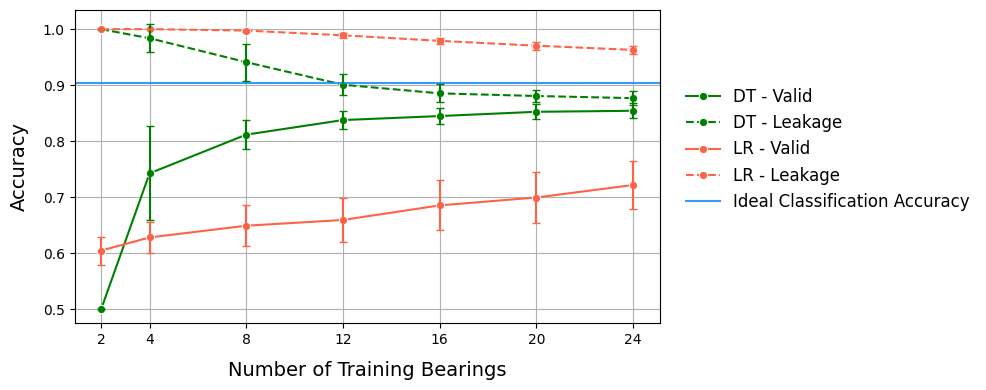

In [113]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#plt.rcParams["font.family"] = "Times New Roman"

df = preds.copy()
metrics = ['DT_acc_test', 'LR_acc_test', 'DT_acc_leak', 'LR_acc_leak']
metrics2 = ['DT', 'LR', 'DT_leakage', 'LR_leakage']

records = []
for metric in metrics:
    for i, row in df.iterrows():
        records.append({
            'n_train_bearings': row['n_train_bearings'],
            'Evaluation': metric,
            'mean': row[f'{metric}_mean'],
            'std': row[f'{metric}_std']
        })

df_long = pd.DataFrame(records)


df_long['Evaluation'] = df_long['Evaluation'].str.replace('_acc_test', '').str.replace('acc_leak', 'leakage')

plt.figure(figsize=(10, 4))
for metric in metrics:
    sns.lineplot(
        data=preds,
        x='n_train_bearings',
        y=metric + '_mean',
        #hue='Evaluation',
        marker='o',
        color='green' if metric.startswith('DT') else 'tomato',
        err_style=None,  # we’ll add our own error bars manually
        label=metric.replace('_acc_test', ' - Valid').replace('_acc_leak', ' - Leakage'),
        linestyle='-' if 'leak' not in metric else '--'
    )


ideal_acc = 0.9030
plt.axhline(y=ideal_acc, color='dodgerblue'
            , label='Ideal Classification Accuracy', alpha=0.9, linewidth=1.5)
# Add error bars manually using std
for _, row in df_long.iterrows():
    plt.errorbar(
        x=row['n_train_bearings'],
        y=row['mean'],
        yerr=row['std'],
        fmt='none',
        capsize=3,
        color='green' if 'DT' in row['Evaluation'] else 'tomato',
    )


handles, labels = plt.gca().get_legend_handles_labels()
order = ['DT - Valid', 'DT - Leakage', 'LR - Valid', 'LR - Leakage', 'Ideal Classification Accuracy']
handles = [handles[labels.index(o)] for o in order if o in labels]
plt.gca().legend(handles=handles, title='', bbox_to_anchor=(1.02, 0.8), frameon=False, fontsize=12)

#plt.title("Toy example \n Comparison of models with and without data leakage", fontsize=16)
plt.xlabel('Number of Training Bearings', fontsize=14, labelpad=10)
plt.ylabel('Accuracy', fontsize=14, labelpad=10)
plt.grid(True)
plt.xticks(df['n_train_bearings'].unique())

plt.tight_layout()
plt.savefig('bearings_comparison.pdf', bbox_inches='tight', dpi=600)
plt.show()

#save figure to PDF


In [112]:
from scipy.stats import norm

def posterior_given_mean_gt_threshold(A, N=3, pi1=0.5):
    pi0 = 1 - pi1
    thresh_scaled = A/2 + np.log(pi0/pi1) / (N * A)
    print(f"Threshold scaled: {thresh_scaled:.4f}")

    scale = 1/ np.sqrt(N)
    p1 = 1 - norm.cdf(thresh_scaled, loc=A, scale=scale)
    p0 = norm.cdf(thresh_scaled, loc=0, scale=scale)

    p = pi1*p1 + pi0*p0

    return p

# Example:
A = 1.5
print(posterior_given_mean_gt_threshold(A, pi1=0.5))


Threshold scaled: 0.7500
0.9030345738587946
